# Basic characterizations of UA Q1
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 0 # for UA Q1
res_index = 0 # for UA Q1
flux_index = 0 # for UA Q1
TLS_index = 0 # for TLS of interest

2024-01-31 13:57:28,780 - qm - INFO     - Starting session: 521cecdb-2bb3-4bbc-bd05-e3bb55e3af5a


In [94]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [5]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [147]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [5]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2023-12-28 16:06:23,107 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2023-12-28 16:06:23,111 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-12-28 16:06:23,128 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [148]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-01-31 15:17:55,348 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 15:17:55,359 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2024-01-31 15:18:02,151 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.392 GHz, -50.000 MHz)
2024-01-31 15:18:14,475 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: 0.000065 V
DC offset to add to Q: -0.000005 V
TOF to add: 0.0 ns


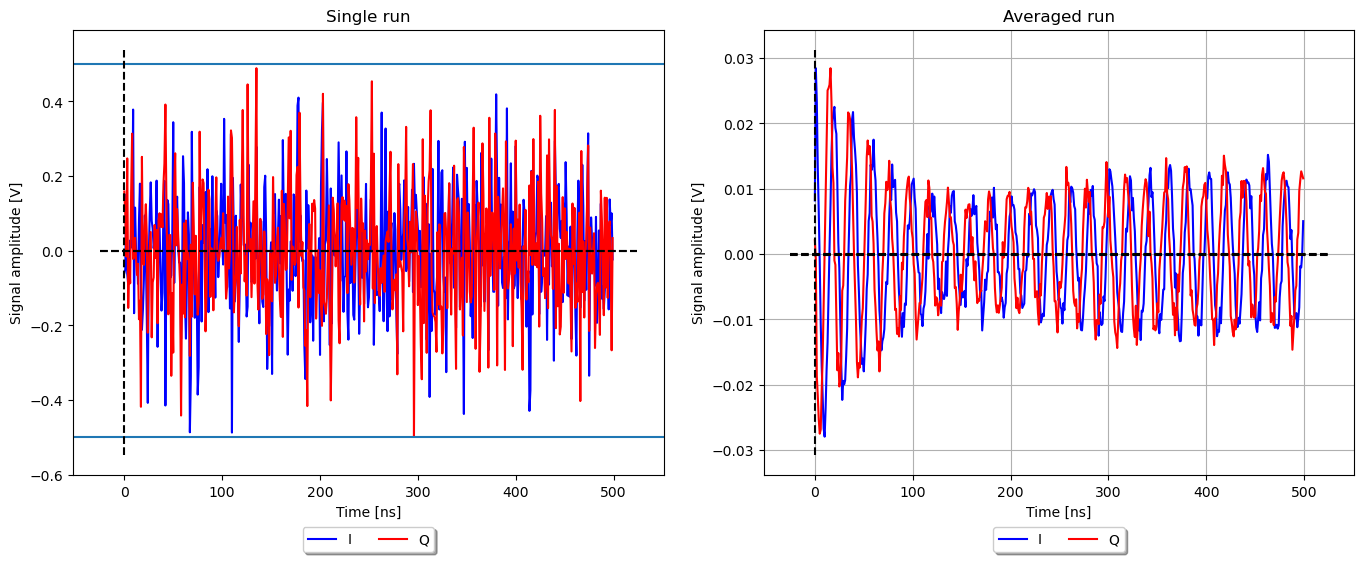

In [48]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [49]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [50]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.02s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.11s


resonator frequency: 7261.779 MHz
Execution stopped by user!


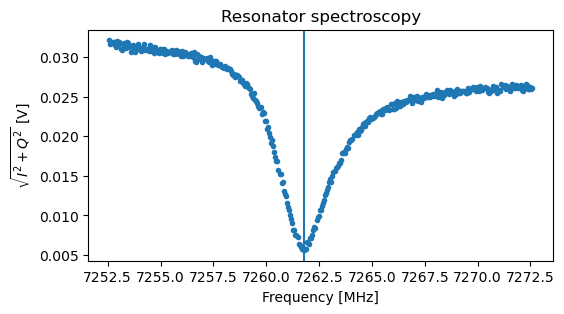

In [51]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine = Analysis.set_machine(machine)

In [20]:
machine.resonators[res_index].f_readout

7261467900.0

## 2D RO resonator spectroscopy vs DC flux

In [53]:
res_freq_sweep = np.arange(7.254E9,7.266E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, n_avg = 10E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)


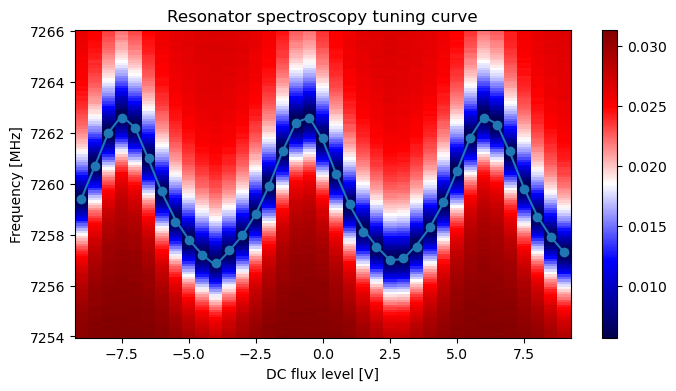

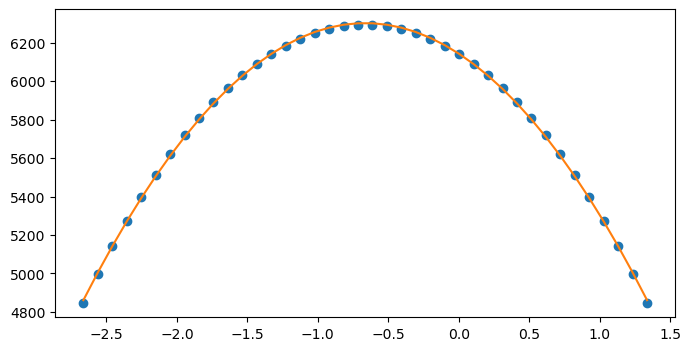

In [55]:
%matplotlib inline
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = None)
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [56]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [57]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [192]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.71s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.76s
resonator frequency: 7262.622 MHz


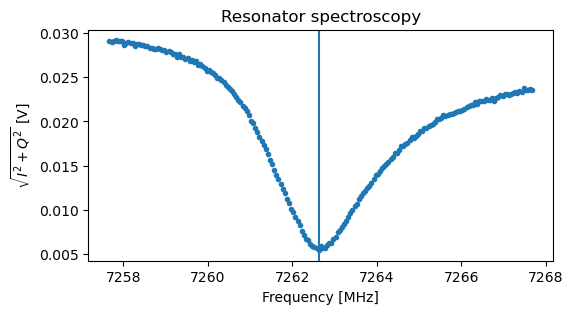

In [124]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [125]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-01-31 14:54:56,935 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 14:54:56,946 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2024-01-31 14:55:03,786 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.352 GHz, -50.000 MHz)
2024-01-31 14:55:16,247 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [193]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-01-31 17:02:15,126 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 17:02:15,136 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2024-01-31 17:02:22,039 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.453 GHz, -50.000 MHz)
2024-01-31 17:02:34,882 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [194]:
if False: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
qubit_freq_sweep = int(qubit_freq_est) + np.arange(-60E6, 60E6 + 1, 1E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.41s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.47s


resonant frequency: 6401.716 MHz


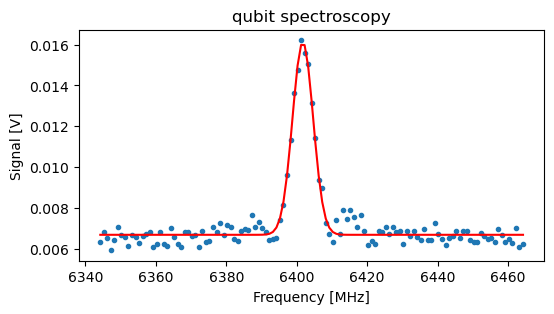

In [196]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [197]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-01-31 17:03:16,036 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 17:03:16,047 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.313 GHz, -50.000 MHz)
2024-01-31 17:03:23,837 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.452 GHz, -50.000 MHz)
2024-01-31 17:03:36,626 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [107]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 40 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.81s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 1.85s


rabi_pi_pulse: 100.3 ns
half period: 96.01 ns


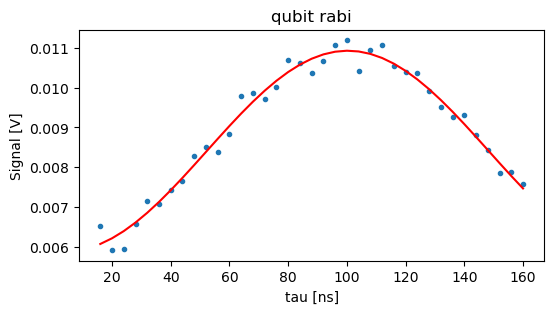

In [108]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [80]:
machine.qubits[qubit_index].pi_length[0] = 100
#machine.qubits[qubit_index].pi_amp[0] = 0.02
machine = Analysis.set_machine(machine)

### power rabi

In [75]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.80s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.85s


rabi_pi_pulse_amp: 0.02154 V
half period: 0.0209137 V


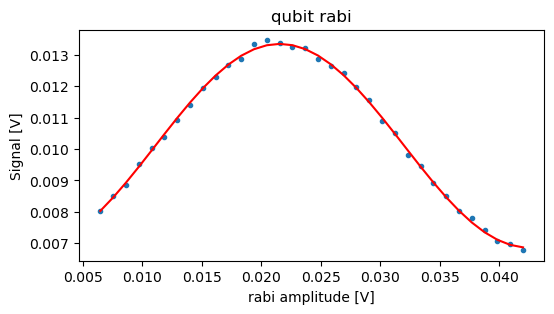

In [76]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [77]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine = Analysis.set_machine(machine)

## T1

In [109]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,500)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 30E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 13.55s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 13.61s


Qubit T1 [us]: 3.6766183366847436


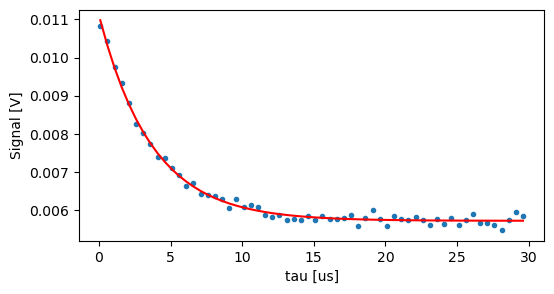

In [110]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [115]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1000 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 10E3, detuning = 1E6, cd_time = 30E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 65.38s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 65.51s
Execution stopped by user!


Qubit T2* [ns]: 2212.311457895529
Detuning [MHz]: 1.607558732726823
Exponent n: 1.6271919433991044


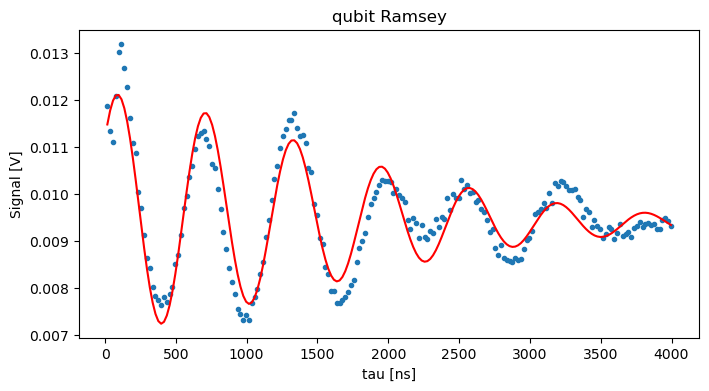

In [116]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [14]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.11s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 4.16s


resonant frequency: 6244.229 MHz


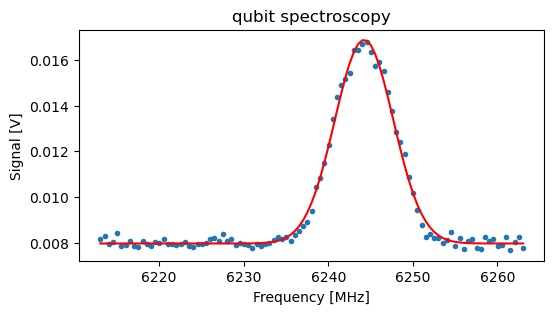

In [15]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [16]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [17]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.13s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.18s


rabi_pi_pulse: 96.4 ns
half period: 94.99 ns


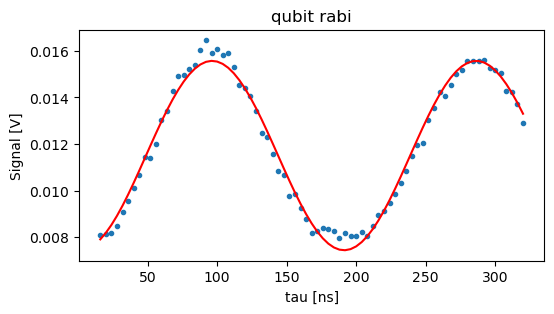

In [18]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [19]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [20]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11.72s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 11.76s


rabi_pi_pulse_amp: 0.02364 V
half period: 0.0162357 V


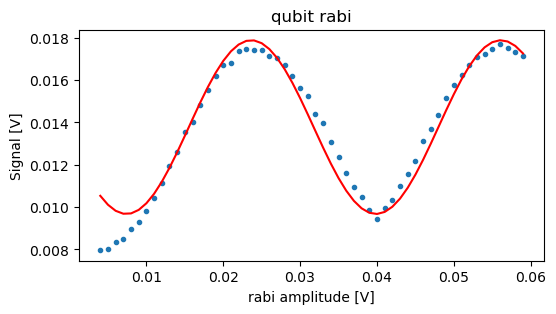

In [21]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [22]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [175]:
machine = Analysis.get_machine()

In [176]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.46,0.46+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

Progress: [##################################################] 100.0% (n=47/47) --> elapsed time: 916.23s


In [177]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.65507 V


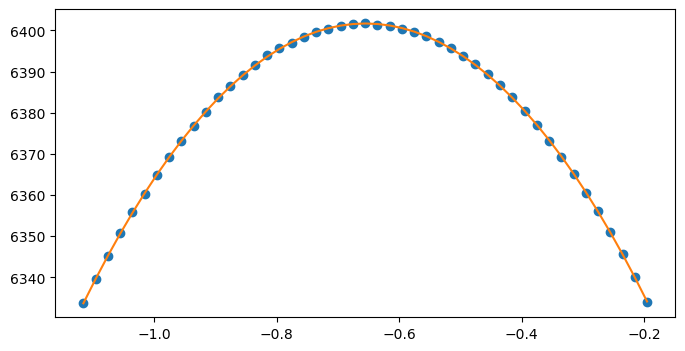

In [179]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [180]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [181]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-01-31 16:51:03,373 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 16:51:03,384 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [188]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.35+1E-4,0.05)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if True: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 4.5, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-01-31 16:59:03,308 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 16:59:03,319 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (6.114 GHz, 290.000 MHz)
2024-01-31 16:59:08,654 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-01-31 16:59:47,282 - qm - INFO     - Performing health check.5% (n=5/8) --> elapsed time: 43.93s


INFO:qm.api.frontend_api:Performing health check


2024-01-31 16:59:47,291 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.831 GHz, 290.000 MHz)
2024-01-31 16:59:52,299 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-01-31 17:00:19,868 - qm - INFO     - Performing health check.5% (n=7/8) --> elapsed time: 76.56s


INFO:qm.api.frontend_api:Performing health check


2024-01-31 17:00:19,877 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.462 GHz, 290.000 MHz)
2024-01-31 17:00:25,778 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=8/8) --> elapsed time: 104.36s
2024-01-31 17:00:47,683 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 17:00:47,693 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.214 GHz, 290.000 MHz)
2024-01-31 17:00:52,958 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


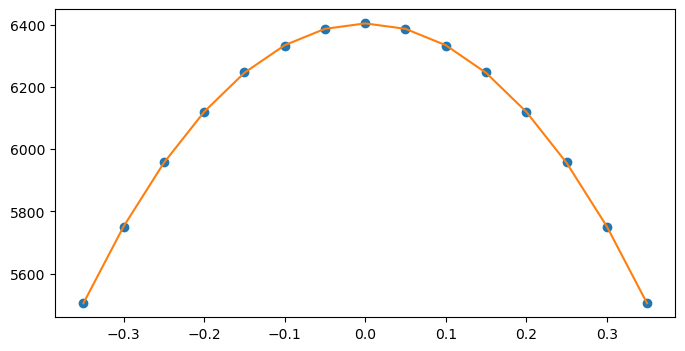

In [190]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [203]:
machine = Analysis.get_machine()

In [204]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 4.5E9, -4E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 25E3, plot_flag = True)

2024-01-31 17:29:43,019 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 17:29:43,033 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2024-01-31 17:29:44,190 - qm - WARNING  - Open QM ended with warning 0: Opening a new Quantum Machine and closing Quantum Machines: 


2024-01-31 17:29:44,193 - qm - WARNING  - Open QM ended with warning 0: Quantum Machine qm-1706750996114 is canceling running job 1702933242799.


------------------------------------- Calibrates q0 for (LO, IF) = (6.103 GHz, 200.000 MHz)
2024-01-31 17:29:48,710 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.32s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.47s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.19s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.35s
2024-01-31 18:22:33,559 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 18:22:33,571 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.903 GHz, 200.000 MHz)
2024-01-31 18:22:39,394 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.43s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.20s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.36s
2024-01-31 19:15:25,188 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 19:15:25,196 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.303 GHz, 200.000 MHz)
2024-01-31 19:15:30,734 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1572.56s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1572.71s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.43s
2024-01-31 20:08:17,467 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 20:08:17,482 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (5.103 GHz, 200.000 MHz)
2024-01-31 20:08:23,144 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.15s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.31s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.23s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.37s
2024-01-31 21:01:07,919 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 21:01:07,929 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (4.503 GHz, 200.000 MHz)
2024-01-31 21:01:13,363 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.27s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1571.42s
2024-01-31 21:27:43,738 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-31 21:27:43,752 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q0 for (LO, IF) = (4.303 GHz, 200.000 MHz)
2024-01-31 21:27:49,467 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 817.03s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 817.18s


<Figure size 800x400 with 0 Axes>

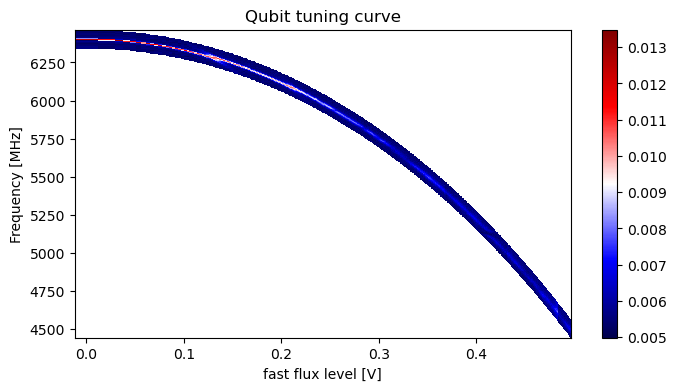

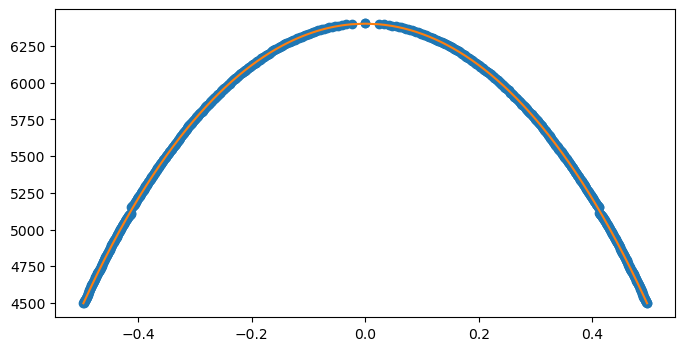

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [205]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

In [223]:
%matplotlib qt
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(qubit_freq_sweep / u.MHz, ff_sweep_abs, sig_amp_qubit, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

# TLS experiments

## TLS SWAP spectroscopy

In [45]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

2023-12-19 12:40:43,620 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-12-19 12:40:43,635 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r0 for (LO, IF) = (7.312 GHz, -50.000 MHz)
2023-12-19 12:40:50,796 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q0 for (LO, IF) = (6.514 GHz, -100.000 MHz)
2023-12-19 12:41:03,384 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


### coarse, no baking

In [68]:
%matplotlib qt
tau_sweep_abs = np.arange(16,160 + 0.1,4)
ff_sweep_abs = np.arange(0.31,0.44,0.002)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 50.49s
Execution stopped by user!


### fine, with baking

In [53]:
%matplotlib qt
tau_sweep_abs = np.arange(4,100,1)
ff_sweep_abs = np.arange(0.15,0.5+1E-4,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 25E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 17227.58s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 17227.75s
Execution stopped by user!


In [71]:
machine.flux_lines[flux_index].iswap.length = [34,23,17,25,20]
machine.flux_lines[flux_index].iswap.level = [0.3015,0.3485,0.431,0.4655,0.4865]
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [55]:
machine = Analysis.get_machine()

In [56]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [57]:
print(freq_tls)

[6219.53151313 6097.94840057 5758.52049471 5512.39772804 5130.13173911
 4772.22098123]


In [87]:
TLS_index = 5

In [88]:
%matplotlib qt
tau_sweep_abs = np.arange(100,400E3+1,10E3)
#tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 500E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Progress: [##################################################] 100.0% (n=4000/4000.0) --> elapsed time: 119.32s


Qubit T1 [us]: 37.42588554606431


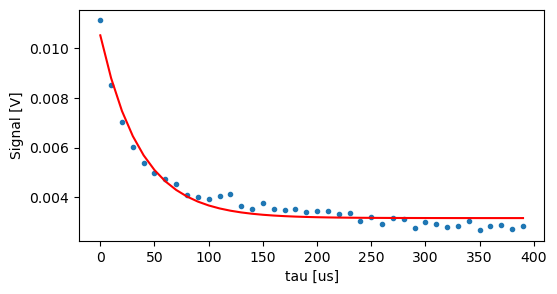

In [90]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [91]:
TLS_index = 2

In [97]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 200E6

In [98]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [100]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2023-12-30 20:21:59,206 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2023-12-30 20:21:59,217 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


2023-12-30 20:22:00,147 - qm - ERROR    - CONFIG ERROR in key "mixers.octave_octave1_2" [mixers.corrections.intermediateFrequency.values] : Mixer 'octave_octave1_2' correction 'FrequencyCorrection(frequency=8.59769748E8, loFrequency=5.558520495E9, correction=CorrectionMatrix(v00=1.0, v01=0.0, v10=0.0, v11=1.0))' has an intermediate frequency greater than 5.0E8


ERROR:qm.api.frontend_api:CONFIG ERROR in key "mixers.octave_octave1_2" [mixers.corrections.intermediateFrequency.values] : Mixer 'octave_octave1_2' correction 'FrequencyCorrection(frequency=8.59769748E8, loFrequency=5.558520495E9, correction=CorrectionMatrix(v00=1.0, v01=0.0, v10=0.0, v11=1.0))' has an intermediate frequency greater than 5.0E8


2023-12-30 20:22:00,149 - qm - ERROR    - CONFIG ERROR in key "elements.q0" [element.intermediateFrequencyUpperLimit] : Element 'q0' has intermediate frequency greater than 5.0E8 (8.59769748E8)


ERROR:qm.api.frontend_api:CONFIG ERROR in key "elements.q0" [element.intermediateFrequencyUpperLimit] : Element 'q0' has intermediate frequency greater than 5.0E8 (8.59769748E8)


OpenQmException: Can not open QM. Please see previous errors

In [ ]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-70E6,70E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

In [ ]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 200E6
machine = Analysis.set_machine(machine)

### TLS rabi

In [ ]:
# save the current qubit to the f_tls[0]
machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1]

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)